In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

In [2]:
def parse_example(example_proto):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example_proto, feature_description)
    
    image = tf.io.parse_tensor(example['image'], out_type=tf.float32)
    image = tf.reshape(image, [122, 122, 3])
    
    label = example['label']
    return image, label

def load_tfrecord(filename):
    dataset = tf.data.TFRecordDataset(filename)
    dataset = dataset.map(parse_example, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

train_ds = load_tfrecord('train.tfrecord')
val_ds = load_tfrecord('val.tfrecord')

train_ds = train_ds.batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(32).prefetch(tf.data.AUTOTUNE)


In [3]:
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau


def create_cnn_model(input_shape=(122, 122, 3), num_classes=8):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), padding='same', input_shape=input_shape,
                      kernel_regularizer=regularizers.l2(0.001)),
        layers.Activation('relu'), 
        layers.BatchNormalization(), 
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), padding='same',
                      kernel_regularizer=regularizers.l2(0.001)),
        layers.Activation('relu'), 
        layers.BatchNormalization(), 
        layers.MaxPooling2D((2, 2)),

        layers.Dropout(0.25),

        layers.Conv2D(128, (3, 3), padding='same',
                      kernel_regularizer=regularizers.l2(0.001)),
        layers.Activation('relu'),
        layers.BatchNormalization(), 
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(256, (3, 3), padding='same',
                      kernel_regularizer=regularizers.l2(0.001)),
        layers.Activation('relu'),
        layers.BatchNormalization(), 
        layers.MaxPooling2D((2, 2)),

        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.5),

        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

lr_reduction = ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    factor=0.5,
    min_lr=1e-6,
    verbose=1
)

model = create_cnn_model()

In [4]:
history = model.fit(train_ds, 
                    validation_data=val_ds, 
                    epochs=30, 
                    callbacks=[early_stop, lr_reduction])

Epoch 1/30
232/232 [==============================] - 12s 30ms/step - loss: 4.2798 - accuracy: 0.1489 - val_loss: 4.2153 - val_accuracy: 0.1332 - lr: 0.0010
Epoch 2/30
232/232 [==============================] - 6s 24ms/step - loss: 3.1635 - accuracy: 0.1777 - val_loss: 2.9845 - val_accuracy: 0.2063 - lr: 0.0010
Epoch 3/30
232/232 [==============================] - 6s 25ms/step - loss: 2.8824 - accuracy: 0.2040 - val_loss: 2.7223 - val_accuracy: 0.2393 - lr: 0.0010
Epoch 4/30
232/232 [==============================] - 6s 24ms/step - loss: 2.6634 - accuracy: 0.2153 - val_loss: 2.5433 - val_accuracy: 0.2523 - lr: 0.0010
Epoch 5/30
232/232 [==============================] - 6s 25ms/step - loss: 2.5851 - accuracy: 0.2416 - val_loss: 4.2245 - val_accuracy: 0.1272 - lr: 0.0010
Epoch 6/30
232/232 [==============================] - 6s 24ms/step - loss: 2.4809 - accuracy: 0.2749 - val_loss: 2.2767 - val_accuracy: 0.3113 - lr: 0.0010
Epoch 7/30
232/232 [==============================] - 6s 25ms/s

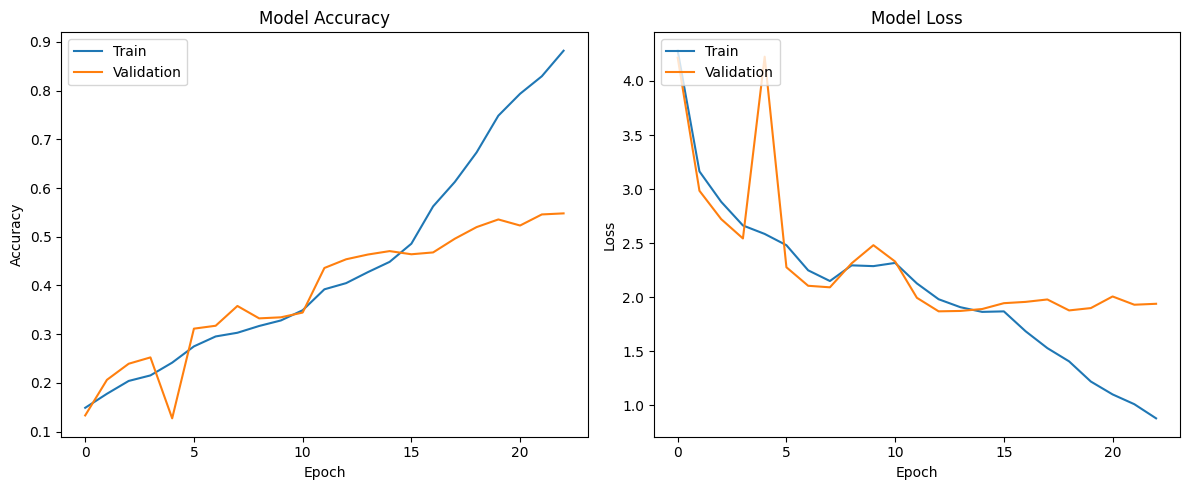

In [5]:


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# model.save("./models/cnn0.66-1.84.h5")